# Kernel methods with noisy setting

## (a)

In [1]:
import scipy.stats as stats
import numpy as np
np.random.seed(100)
plus_train = stats.multivariate_normal.rvs(mean=[1,1], cov=[[1,0],[0,1]], size=1000)
minus_train = stats.multivariate_normal.rvs(mean=[-1,-1], cov=[[3,0],[0,3]], size=1000)
train = np.concatenate((plus_train,minus_train))
plus_test = stats.multivariate_normal.rvs(mean=[1,1], cov=[[1,0],[0,1]], size=1000)
minus_test = stats.multivariate_normal.rvs(mean=[-1,-1], cov=[[3,0],[0,3]], size=1000)
test = np.concatenate((plus_test,minus_test))

train_labels = np.array([1] * 1000 + [-1] * 1000)
test_labels = np.array([1] * 1000 + [-1] * 1000)

In [2]:
def flip_labels(labels):
    to_minus_prob = np.concatenate((stats.uniform.rvs(size=1000), np.ones(1000)))
    to_plus_prob = np.concatenate((np.ones(1000),stats.uniform.rvs(size=1000)))
    randomized_labels = labels.copy()
    randomized_labels[to_minus_prob <= 0.35] = -1
    randomized_labels[to_plus_prob <= 0.2] = 1
    return(randomized_labels)

In [3]:
from sklearn.svm import SVC

np.random.seed(2020)
a_accuracy = []
a_sums = []
for i in range(20):
    noisy_labels = flip_labels(train_labels)
    a_sums.append(sum(noisy_labels))
    svm_a = SVC(kernel="rbf", C=1, gamma=0.01)
    svm_a.fit(train,noisy_labels)
    a_accuracy.append(svm_a.score(test, test_labels))
np.mean(a_accuracy)

0.8102499999999999

The average is around 0.81

## (b)

In [4]:
from sklearn.neighbors import KNeighborsClassifier

np.random.seed(2020)
b_accuracy = []
b_sums = []
for i in range(20):
    noisy_labels = flip_labels(train_labels)
    KNN = KNeighborsClassifier(n_neighbors=19)
    KNN.fit(train, noisy_labels)
    fixed_labels = KNN.predict(train)
    b_sums.append(sum(fixed_labels))
    svm_b = SVC(kernel="rbf", C=1, gamma=0.01)
    svm_b.fit(train,fixed_labels)
    b_accuracy.append(svm_b.score(test, test_labels))
np.mean(b_accuracy)

0.8528249999999999

In [5]:
np.transpose(b_accuracy)

array([0.8435, 0.8535, 0.8545, 0.8485, 0.845 , 0.851 , 0.861 , 0.8505,
       0.8495, 0.855 , 0.8395, 0.855 , 0.8525, 0.862 , 0.858 , 0.8575,
       0.858 , 0.8675, 0.8465, 0.848 ])

$k$ was chosen empirically and 19 seems to give the highest accuracy. It looks like there is a definite improvement, around 5%. Though we repeated the process 20 times to make sure the improvement is not by chance, it seems that each time is higher than 80\% anyway.

## (c)

In [6]:
from sklearn.cluster import KMeans

np.random.seed(2020)
c_accuracy = []
c_sums = []
for i in range(20):
    noisy_labels = flip_labels(train_labels)
    KM = KMeans(n_clusters=2)
    KM.fit(train)
    fixed_labels_KM = KM.predict(train)
    fixed_labels_KM[fixed_labels_KM == 0] = -1
    c_sums.append(sum(fixed_labels_KM))
    svm_c = SVC(kernel="rbf", C=1, gamma=0.01)
    svm_c.fit(train, fixed_labels_KM)
    c_accuracy.append(svm_c.score(test, test_labels))
np.mean(c_accuracy)

0.39635

In [7]:
KM.cluster_centers_

array([[ 0.97198463,  0.91039327],
       [-1.54659148, -1.46298677]])

$k$ was chosen to be 2 because we know that there are 2 clusters. There is a marked decrease in performance. One of the cluster centers (0.972, 0.910) was close to the mean we used to generate the data, but the other is not, which explains why. Also, increasing this parameter seems to make the accuracy worse. Overall, this method seems to make the data noisier and would not be recommended as a way to "fix" the labels.

# Fairness

In [8]:
import sqlalchemy
engine = sqlalchemy.create_engine('sqlite:///compas.db')
inspector = sqlalchemy.inspect(engine)
inspector.get_table_names()

['casearrest',
 'charge',
 'compas',
 'jailhistory',
 'people',
 'prisonhistory',
 'summary']

In [9]:
cursor = engine.execute('SELECT * FROM compas LIMIT 10')
cursor.fetchall()

[(1, 'miguel', 'hernandez', 56418, 58393, 64352, 'PRETRIAL', 'Risk and Prescreen', 'Intake', 'Pretrial', 'Jail Inmate', 'Single', '2013-08-14 00:00:00.000000', 1, 'Low', 'Low', 7, 'Risk of Violence', -4.31, 1, 1),
 (2, 'miguel', 'hernandez', 56418, 58393, 64352, 'PRETRIAL', 'Risk and Prescreen', 'Intake', 'Pretrial', 'Jail Inmate', 'Single', '2013-08-14 00:00:00.000000', 1, 'Low', 'Low', 8, 'Risk of Recidivism', -2.78, 1, 1),
 (3, 'miguel', 'hernandez', 56418, 58393, 64352, 'PRETRIAL', 'Risk and Prescreen', 'Intake', 'Pretrial', 'Jail Inmate', 'Single', '2013-08-14 00:00:00.000000', 1, 'Low', 'Low', 18, 'Risk of Failure to Appear', 13, 1, 1),
 (4, 'michael', 'ryan', 68603, 72042, 79669, 'PRETRIAL', 'Risk and Prescreen', 'Intake', 'Pretrial', 'Jail Inmate', 'Single', '2014-12-31 00:00:00.000000', 1, 'Low', 'Low', 7, 'Risk of Violence', -2.75, 2, 2),
 (5, 'michael', 'ryan', 68603, 72042, 79669, 'PRETRIAL', 'Risk and Prescreen', 'Intake', 'Pretrial', 'Jail Inmate', 'Single', '2014-12-31 0

In [10]:
# Import the table "people" from the database into pandas
import pandas
people = pandas.read_sql('people', engine)
people.head()

,id,name,first,last,sex,race,dob,age,age_cat,juv_fel_count,...,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,is_violent_recid,num_vr_cases,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc
0,1,miguel hernandez,miguel,hernandez,Male,Other,1947-04-18,69,Greater than 45,0,...,NaT,None,NaT,NaT,0,None,None,None,NaT,None
1,2,michael ryan,michael,ryan,Male,Caucasian,1985-02-06,31,25 - 45,0,...,NaT,None,NaT,NaT,0,None,None,None,NaT,None
2,3,kevon dixon,kevon,dixon,Male,African-American,1982-01-22,34,25 - 45,0,...,2013-07-05,Felony Battery (Dom Strang),NaT,NaT,1,None,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang)
3,4,ed philo,ed,philo,Male,African-American,1991-05-14,24,Less than 25,0,...,2013-06-16,Driving Under The Influence,2013-06-16 09:05:47,2013-06-16 07:18:55,0,None,None,None,NaT,None
4,5,marcu brown,marcu,brown,Male,African-American,1993-01-21,23,Less than 25,0,...,NaT,None,NaT,NaT,0,None,None,None,NaT,None


In [11]:
people.columns

Index(['id', 'name', 'first', 'last', 'sex', 'race', 'dob', 'age', 'age_cat',
       'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'compas_screening_date', 'decile_score', 'score_text', 'violent_recid',
       'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
       'c_case_number', 'c_days_from_compas', 'c_arrest_date',
       'c_offense_date', 'c_charge_degree', 'c_charge_desc', 'is_recid',
       'num_r_cases', 'r_case_number', 'r_charge_degree', 'r_days_from_arrest',
       'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out',
       'is_violent_recid', 'num_vr_cases', 'vr_case_number',
       'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc'],
      dtype='object')

In [12]:
# Import the table "compas" from the database into pandas
# COMPAS is the risk assessment tool used in the article and is the subject of study
compas = pandas.read_sql('compas', engine)
compas.head()

,id,first,last,compas_person_id,compas_case_id,compas_assessment_id,agency_text,scale_set,assessment_reason,legal_status,...,marital_status,screening_date,rec_supervision_level,rec_supervision_level_text,score_text,scale_id,type_of_assessment,raw_score,decile_score,person_id
0,1,miguel,hernandez,56418,58393,64352,PRETRIAL,Risk and Prescreen,Intake,Pretrial,...,Single,2013-08-14,1,Low,Low,7,Risk of Violence,-4,1,1
1,2,miguel,hernandez,56418,58393,64352,PRETRIAL,Risk and Prescreen,Intake,Pretrial,...,Single,2013-08-14,1,Low,Low,8,Risk of Recidivism,-2,1,1
2,3,miguel,hernandez,56418,58393,64352,PRETRIAL,Risk and Prescreen,Intake,Pretrial,...,Single,2013-08-14,1,Low,Low,18,Risk of Failure to Appear,13,1,1
3,4,michael,ryan,68603,72042,79669,PRETRIAL,Risk and Prescreen,Intake,Pretrial,...,Single,2014-12-31,1,Low,Low,7,Risk of Violence,-2,2,2
4,5,michael,ryan,68603,72042,79669,PRETRIAL,Risk and Prescreen,Intake,Pretrial,...,Single,2014-12-31,1,Low,Medium,8,Risk of Recidivism,0,5,2


In [13]:
compas.columns

Index(['id', 'first', 'last', 'compas_person_id', 'compas_case_id',
       'compas_assessment_id', 'agency_text', 'scale_set', 'assessment_reason',
       'legal_status', 'custody_status', 'marital_status', 'screening_date',
       'rec_supervision_level', 'rec_supervision_level_text', 'score_text',
       'scale_id', 'type_of_assessment', 'raw_score', 'decile_score',
       'person_id'],
      dtype='object')

In [14]:
# Inner join the tables. Compare empirical data (times reoffended) with predicted (compas risk)

df = pandas.read_sql('''SELECT race,is_violent_recid,agency_text,compas.score_text 
FROM people JOIN compas ON 
person_id = people.id''', engine)
df.head()

,race,is_violent_recid,agency_text,score_text
0,Other,0,PRETRIAL,Low
1,Other,0,PRETRIAL,Low
2,Other,0,PRETRIAL,Low
3,Caucasian,0,PRETRIAL,Low
4,Caucasian,0,PRETRIAL,Medium


In [15]:
relative_counts = pandas.DataFrame(
    {i: d.score_text.value_counts() / d.score_text.count()
     for i, d in df.groupby(['race', 'is_violent_recid'])})
relative_counts

African-American               Asian           Caucasian            \
                      0         1         0         1         0         1   
High           0.168173  0.290386  0.041667  0.166667  0.076904  0.142686   
Low            0.576348  0.399707  0.839286  0.416667  0.742984  0.594724   
Medium         0.255006  0.309907  0.119048  0.416667  0.179191  0.262590   
N/A            0.000473       NaN       NaN       NaN  0.000922       NaN   

        Hispanic           Native American               Other            
               0         1               0         1         0         1  
High    0.065251  0.159204        0.117117  0.277778  0.025402  0.191489  
Low     0.780240  0.621891        0.711712  0.388889  0.855365  0.666667  
Medium  0.154509  0.218905        0.171171  0.333333  0.118196  0.141844  
N/A          NaN       NaN             NaN       NaN  0.001037       NaN

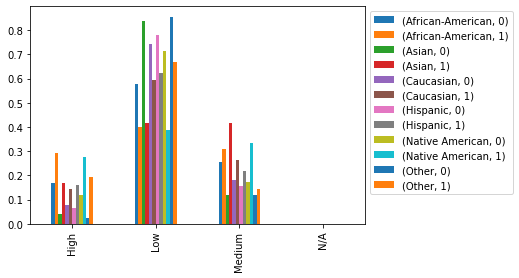

In [16]:
%matplotlib inline
relative_counts.plot.bar().legend(bbox_to_anchor = (1,1))

In [17]:
# this will be your prediction
df['scored_high'] = 0 + (df.score_text == 'High')

In [18]:
from statsmodels.formula.api import logit
#this will be the model you used to generate scores
# C() for categorical
model = logit('scored_high ~ C(race) + is_violent_recid + agency_text', df).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.365167
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            scored_high   No. Observations:                37578
Model:                          Logit   Df Residuals:                    37568
Method:                           MLE   Df Model:                            9
Date:                Mon, 14 Dec 2020   Pseudo R-squ.:                 0.04752
Time:                        13:19:34   Log-Likelihood:                -13722.
converged:                       True   LL-Null:                       -14407.
Covariance Type:            nonrobust   LLR p-value:                3.681e-289
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.9779      0.230     -4.248      0.000      -1.429      -0.527
C(race)[T.Asian]              -1.4142      0.343     -4.122      0.000      -2.087      -0.742
C(race)[T.Caucasian]          -0.8806      0.038    -23.374      0.000      -0.954      -0.807
C(race)[T.Hispanic]           -1.0405      0.069    -15.008      0.000      -1.176      -0.905
C(race)[T.Native American]    -0.3605      0.256     -1.406      0.160      -0.863       0.142
C(race)[T.Other]              -1.7172      0.119    -14.478      0.000      -1.950      -1.485
agency_text[T.DRRD]            0.2336      0.294      0.795      0.427      -0.342       0.809
agency_text[T.PRETRIAL]       -0.6537      0.231     -2.836      0.005      -1.105      -0.202
agency_text[T.Probation]      -0.2184      0.241     -0.905      0.366      -0.692       0.255
is_violent_recid               0.7479      0.045     16.515      0.000       0.659       0.837
==============================================================================================
"""

In [19]:
score = model.predict(df)

In [20]:
bw_score = score[(df["race"] == "African-American") | (df["race"] == "Caucasian") ]

In [21]:
max_score = max(bw_score)
max_score

0.500899933158618

In [22]:
min_score = min(bw_score)
min_score

0.07501360138832201

## (a) Independence

In [23]:
df_BW = df[(df["race"] == "Caucasian") | (df["race"] == "African-American")]
df_BW = df_BW.assign(R=(df_BW["scored_high"] >= np.mean(df_BW["scored_high"]))*1)

In [24]:
P_W = sum((df_BW["race"] == "African-American") & (df_BW["R"] == 1))/sum((df_BW["race"] == "African-American"))
P_B = sum((df_BW["race"] == "Caucasian") & (df_BW["R"] == 1))/sum((df_BW["race"] == "Caucasian"))
P_W/P_B

2.2336060238455064

In [25]:
np.mean(df_BW["scored_high"])

0.1410753094585656

Using the empirical threshold of $0.141$, the ratio evaluates to $2.23 > 0.8$. Therefore, the model violates disparate impact law 

## (b) Separation

In [26]:
def calc_TFPR(true, pred, n_thresh) :
    x = np.linspace(min_score,max_score,n_thresh+1)
    TPRs = []
    FPRs = []
    for thresh in x[0:n_thresh]:
        converted_pred = (pred >= thresh)*1
        TP = sum((true == 1) & (converted_pred == 1))
        act_P = sum(true == 1)
        TPR = TP/act_P
        TPRs.append(TPR)
        FP = sum((true == 0) & (converted_pred == 1))
        act_N = sum(true == 0)
        FPR = FP/act_N
        FPRs.append(FPR)
    df = pandas.DataFrame(zip(x[0:n_thresh], TPRs, FPRs), 
               columns =['Lower Threshold', 'TPR', 'FPR'])
    return(df)

In [27]:
W_filter = df["race"] == "Caucasian"
W = df[W_filter]
W_score = score[W_filter]
TFPR_W = calc_TFPR(W["is_violent_recid"], W_score, 100)
TFPR_W

,Lower Threshold,TPR,FPR
0,0.075014,1.0,1.000000
1,0.079272,1.0,0.036441
2,0.083531,1.0,0.036441
3,0.087790,1.0,0.036441
4,0.092049,1.0,0.036441
...,...,...,...
95,0.479606,0.0,0.000000
96,0.483864,0.0,0.000000
97,0.488123,0.0,0.000000
98,0.492382,0.0,0.000000


Text(0.5, 1.0, 'ROC Curve - Caucasian')

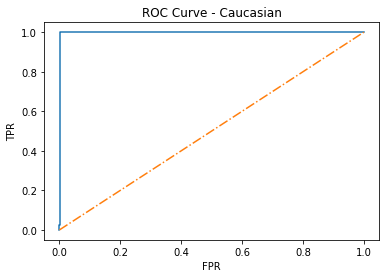

In [28]:
import matplotlib.pyplot as plt

plt.plot(TFPR_W["FPR"], TFPR_W["TPR"])
plt.plot([0,1],[0,1],linestyle='-.')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve - Caucasian")

In [29]:
B_filter = df["race"] == "African-American"
B = df[B_filter]
B_score = score[B_filter]
TFPR_B = calc_TFPR(B["is_violent_recid"], B_score, 100)
TFPR_B

,Lower Threshold,TPR,FPR
0,0.075014,1.000000,1.0
1,0.079272,1.000000,1.0
2,0.083531,1.000000,1.0
3,0.087790,1.000000,1.0
4,0.092049,1.000000,1.0
...,...,...,...
95,0.479606,0.013177,0.0
96,0.483864,0.013177,0.0
97,0.488123,0.013177,0.0
98,0.492382,0.013177,0.0


Text(0.5, 1.0, 'ROC Curve - African-American')

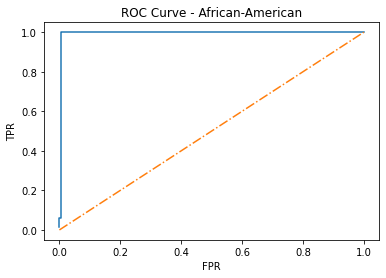

In [30]:
plt.plot(TFPR_B["FPR"], TFPR_B["TPR"])
plt.plot([0,1],[0,1],linestyle='-.')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve - African-American")

## (c) Achieve Separation by Post-Processing

The ideal TPR is 1 and the ideal FPR is 0. This would mean we should look for separation errors of 0. However, if the TPR for both groups is 0 and the FPR is 1, this also gives 0, and likewise if both the TPR and the FPR are 0. In terms of the ROC curve, we want the TPR and FPR corresponding to the upper left hand corner, with TPR = 1, FPR $\approx$ 0. 

In [31]:
# oz stands for one zero
oz_TFPR_W = TFPR_W[(TFPR_W["TPR"] > 0) & (TFPR_W["FPR"] < 1)]
oz_TFPR_B = TFPR_B[(TFPR_B["TPR"] > 0) & (TFPR_B["FPR"] < 1)]

In [32]:
oz_TFPR_W.head()

,Lower Threshold,TPR,FPR
1,0.079272,1.0,0.036441
2,0.083531,1.0,0.036441
3,0.087790,1.0,0.036441
4,0.092049,1.0,0.036441
5,0.096308,1.0,0.036441


In [33]:
oz_TFPR_B.head()

,Lower Threshold,TPR,FPR
21,0.164450,1.0,0.041645
22,0.168709,1.0,0.041645
23,0.172967,1.0,0.041645
24,0.177226,1.0,0.041645
25,0.181485,1.0,0.041645


In [34]:
TPR_term = np.abs(np.subtract.outer(list(oz_TFPR_W["TPR"]), list(oz_TFPR_B["TPR"])))
FPR_term = np.abs(np.subtract.outer(list(oz_TFPR_W["FPR"]), list(oz_TFPR_B["FPR"])))
sep_error = TPR_term + FPR_term

In [35]:
x = oz_TFPR_W["Lower Threshold"]
y = oz_TFPR_B["Lower Threshold"]
coords = np.argwhere(sep_error == np.min(sep_error))
pairs = [[x[w],y[b]] for w, b in zip(coords[:,0], coords[:,1])]

In [36]:
pairs = pandas.DataFrame(pairs, columns=["Caucasian", "African-American"])
pairs

,Caucasian,African-American
0,0.109085,0.185744
1,0.109085,0.190003
2,0.109085,0.194262
3,0.109085,0.198521
4,0.109085,0.202780
5,0.113343,0.185744
6,0.113343,0.190003
7,0.113343,0.194262
8,0.113343,0.198521
9,0.113343,0.202780


The table above are pairs of thresholds that would give the lowest separation error while maximizing TPR and minimizing FPR. The first column is the threshold for Caucasians and the second is for African-American. We can see from the table that the threshold is lower for Caucasians than African-Americans. We can also see this in the mean and median below. Recall that the score, the output from logistic regression, is the predicted probability of scoring high. Our goal is to look for bias in the COMPAS scoring system. We can see that this model implies that African-Americans more likely to get a high COMPAS score. Therefore, it suggests that there is bias in the COMPAS score, as race makes a big difference in the model.

In [37]:
pairs.describe()

,Caucasian,African-American
count,30.000000,30.000000
mean,0.119732,0.194262
std,0.007398,0.006126
min,0.109085,0.185744
25%,0.113343,0.190003
50%,0.119732,0.194262
75%,0.126120,0.198521
max,0.130379,0.202780
